# Adaption to new classes
project 7 by Guanzhao Wang, Haochen Wu, Yukai Wang

### Abstact outline:
In this project, the goal is to find a way conbines unsupervised and supervised method. 

A classification model is trained under labelled categories on Fashion-MNIST dataset. Then, new categories are added without labels. There are several unsupervised clustering methods implemented and compared. The classification model will based on the pretrained model from supervised images and retrained with the categories labelled by the unsupervised methods.

### Teammates:
- Guanzhao Wang:

- Haochen Wu:

- Yukai Wang:

In [1]:
from mylibs.dataloader import getTrainValidateLoaders, getTestLoaders
from mylibs.train import train
from mylibs.eval import validate
from mylibs.model import Net, CustomFashionResNet
from mylibs.loss import loss_function
from mylibs.report import report_epoch_summary, report_summary
from mylibs.save import save, load

import torch
from torchvision import transforms
import os

In [3]:
USE_GPU = True
BATCH_SIZE = 64
EPOCH = 10
NUM_WORKERS = 2
K = 7

In [4]:
device = torch.device("cuda" if USE_GPU else "cpu")

transform = transforms.Compose([
    transforms.ToTensor()
])

mode_description = {0: "clustering: kmeans",
                    1: "clustering: kmeans with PCA",
                    2: "clustering: kmeans with Auto Encoder",
                    3: "clustering: Gaussian Mixture",
                    4: "clustering: Gaussian Mixture with PCA",
                    5: "clustering: Gaussian Mixture with Auto Encoder",
                    6: "use only labeled data",
                    7: "use full FasionMNIST data",
                   }

mode_metrics = {}

In [5]:
def whole_flow(mode, useResnet):
    print(f"Getting train and validate dataloaders for mode {mode}: {mode_description[mode]}")
    train_val_loaders = getTrainValidateLoaders(include_labels=range(K), transform=transform, batch_size=BATCH_SIZE, split=0.9, num_workers=NUM_WORKERS, mode=mode, USE_GPU=USE_GPU)
    if useResnet:
        model = CustomFashionResNet(color_scale = 1, num_classes = 10).to(device)
    else:
        model = Net().to(device)
    optimizer = torch.optim.Adadelta(model.parameters(), lr=0.01)
    eval_metrics = []

    model_name = "ResNet" if useResnet else "Net"
    checkpoint_path = f"./checkpoint/mode_{mode}/{model_name}"
    os.makedirs(checkpoint_path, exist_ok=True)
    
    print(f"Start Training... {model_name}")
    # scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, EPOCH+1):
        eval_metric = train(train_val_loaders, model, loss_function, optimizer, USE_GPU, f"{checkpoint_path}/epoch_{epoch}.pt")
        eval_metrics.append(eval_metric)
        print(f"Epoch: {epoch}")
        print(f"\tTrain         - Loss: {eval_metric['train']['loss']:.4f} Accuracy: {eval_metric['train']['acc']:.4f} F1_score: {eval_metric['train']['f1']:.4f}")
        print(f"\tValidation    - Loss: {eval_metric['val']['loss']:.4f} Accuracy: {eval_metric['val']['acc']:.4f} F1_score: {eval_metric['val']['f1']:.4f}")

    report_epoch_summary(eval_metrics)
    
    all_val_f1 = [x['val']['f1'] for x in eval_metrics]
    best_epoch = all_val_f1.index(max(all_val_f1)) + 1
    print(f"Loading model at epoch {best_epoch} for best validation f1")
    checkpoint = torch.load(f"{checkpoint_path}/epoch_{epoch}.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    print("Preparing test loaders")
    labeled_test_loader, unlabeled_test_loader, test_loader = getTestLoaders(include_labels=range(K), transform=transform, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, USE_GPU=USE_GPU)
    
    model.eval()
    eval_metric = validate(labeled_test_loader, model, loss_function, USE_GPU)
    print(f"Result on labelled test set  : Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")

    eval_metric = validate(unlabeled_test_loader, model, loss_function, USE_GPU)
    print(f"Result on unlabelled test set: Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")

    eval_metric = validate(test_loader, model, loss_function, USE_GPU)
    print(f"Result on full test set      : Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")
    
    return eval_metrics

## Baseline #1, use only first K-class labelled data to train

Getting train and validate dataloaders for mode 6: use only labeled data
Start Training... Net
Epoch: 1
	Train         - Loss: 0.5997 Accuracy: 0.7921 F1_score: 0.7891
	Validation    - Loss: 0.4513 Accuracy: 0.8376 F1_score: 0.8379
Epoch: 2
	Train         - Loss: 0.4175 Accuracy: 0.8479 F1_score: 0.8468
	Validation    - Loss: 0.3961 Accuracy: 0.8598 F1_score: 0.8587
Epoch: 3
	Train         - Loss: 0.3727 Accuracy: 0.8657 F1_score: 0.8649
	Validation    - Loss: 0.3732 Accuracy: 0.8669 F1_score: 0.8647
Epoch: 4
	Train         - Loss: 0.3450 Accuracy: 0.8757 F1_score: 0.8750
	Validation    - Loss: 0.3531 Accuracy: 0.8717 F1_score: 0.8716
Epoch: 5
	Train         - Loss: 0.3257 Accuracy: 0.8834 F1_score: 0.8829
	Validation    - Loss: 0.3404 Accuracy: 0.8786 F1_score: 0.8763
Epoch: 6
	Train         - Loss: 0.3093 Accuracy: 0.8912 F1_score: 0.8906
	Validation    - Loss: 0.3303 Accuracy: 0.8821 F1_score: 0.8813
Epoch: 7
	Train         - Loss: 0.2956 Accuracy: 0.8962 F1_score: 0.8958
	Validatio

<Figure size 432x288 with 0 Axes>

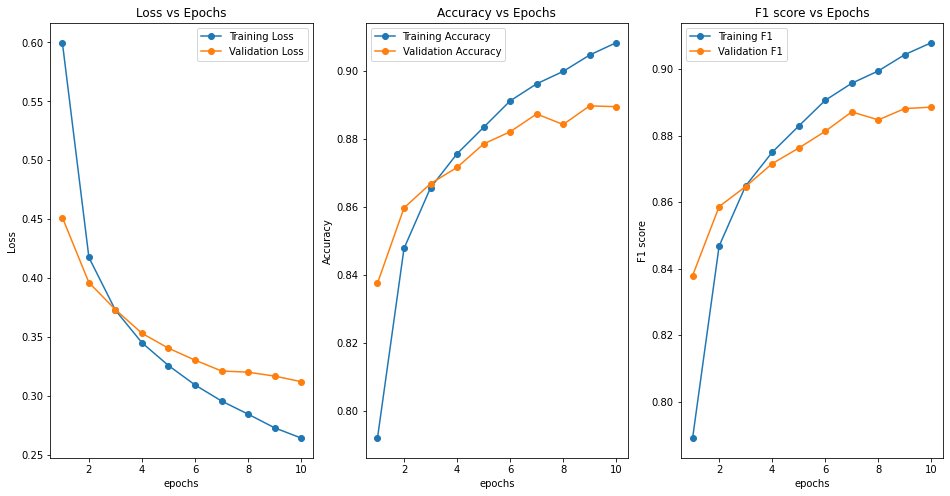

Loading model at epoch 10
Preparing test loaders
Result on labelled test set  : Loss: 0.3416 Accuracy: 0.8723 F1_score: 0.8708
Result on unlabelled test set: Loss: 10.2908 Accuracy: 0.0000 F1_score: 0.0000
Result on full test set      : Loss: 3.3223 Accuracy: 0.6106 F1_score: 0.5262


In [8]:
mode_metric = whole_flow(6, False)
mode_metrics[6] = mode_metric

## Baseline #2, use full Fashion-MNIST dataset to train

In [ ]:
mode_metric = whole_flow(7, False)
mode_metrics[7] = mode_metric

# Label new categories by clustering

- label the dataset under different clustering methods
- compare acuracy on the test set

## Approach #1, use KMeans to compute label for unlabelled data

## Approach #2, use KMeans with PCA to compute label for unlabelled data

In [5]:
mode_metric = whole_flow(2, False)
mode_metrics[2] = mode_metric

Getting train and validate dataloaders for mode 2: clustering: kmeans with Auto Encoder
Labeling unlabeled data...
Training Auto Encoder...


TypeError: conv2d(): argument 'padding' (position 5) must be tuple of ints, not str

## Approach #3, use KMeans with Auto Encoder to compute label for unlabelled data

## Approach #4, use Gaussian Mixture to compute label for unlabelled data

## Approach #5, use Gaussian Mixture with PCA to compute label for unlabelled data

## Approach #6, use Gaussian Mixture with Auto Encoder to compute label for unlabelled data

In [6]:
report_summary(mode_metrics, mode_description)

## Conclusion